<a href="https://colab.research.google.com/github/guillermocalderon2021/tfm-words-embeddings/blob/main/20News_ModelosClasicosipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargando dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/20_group/')

import pandas as pd
df = pd.read_csv("20newsgroup_preprocessed.csv", sep=';', usecols=['target', 'text','text_cleaned'])
df.head()

Mounted at /content/drive


,target,text,text_cleaned
0,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,atheist resources addresses atheist organizati...
1,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,begin pgp signed message introduction atheism ...
2,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,article charley wingate writes well john quite...
3,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,kings become philosophers philosophers become ...
4,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,article bob mcgwier writes however hate econom...


In [ ]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(df[['text_cleaned','text']], df['target'], random_state=42, train_size = .80)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=42, train_size = .80)


print('tamaño del conjunto de entrenamiento: ', X_train.shape)
print('tamaño del conjunto de validación: ', X_val.shape)
print('tamaño del conjunto de test: ', X_test.shape)


tamaño del conjunto de entrenamiento:  (12049, 2)
tamaño del conjunto de validación:  (3013, 2)
tamaño del conjunto de test:  (3766, 2)


In [ ]:
X_train['text_cleaned'] = X_train['text_cleaned'].fillna('')
X_val['text_cleaned'] = X_val['text_cleaned'].fillna('')
X_test['text_cleaned'] = X_test['text_cleaned'].fillna('')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
X_train['text_cleaned'] = X_train['text_cleaned'].apply(preprocess)
X_val['text_cleaned'] = X_val['text_cleaned'].apply(preprocess)
X_test['text_cleaned'] = X_test['text_cleaned'].apply(preprocess)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Inicializa el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajusta el codificador y transforma las etiquetas de texto a números
y_train_num = label_encoder.fit_transform(y_train)
y_val_num = label_encoder.transform(y_val)
y_test_num = label_encoder.transform(y_test)
# Obtener los nombres de las etiquetas
label_names = label_encoder.inverse_transform(range(len(set(y_train_num))))
print(y_test_num)

[ 2  3  0 ... 11 15  7]


# Frecuencias

In [ ]:
# Frecuencias
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectors_train = vectorizer.fit_transform(X_train['text_cleaned'])
vectors_val = vectorizer.transform(X_val['text_cleaned'])
vectors_test = vectorizer.transform(X_test['text_cleaned'])


In [ ]:
# Para validación cruzada
from scipy.sparse import vstack
import numpy as np

vectors_train = vstack([vectors_train, vectors_val])


In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(X_train['text_cleaned'])
vectors_val = vectorizer.transform(X_val['text_cleaned'])
vectors_test = vectorizer.transform(X_test['text_cleaned'])

In [ ]:
# Para validación cruzada
from scipy.sparse import vstack
import numpy as np

vectors_train = vstack([vectors_train, vectors_val])


In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

# Embedding estaticos

In [ ]:
def vectorize_text(text, model):
    vectors = [model[word] for word in text.split() if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
models=['fasttext-wiki-news-subwords-300',  'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100',
        'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-200')


[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
word2_vectors=glove_vectors

In [ ]:
import gensim.downloader
word2_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
import numpy as np
vectors_train = np.array([vectorize_text(text, word2_vectors) for text in X_train['text_cleaned']])
vectors_val = np.array([vectorize_text(text, word2_vectors) for text in X_val['text_cleaned']])
vectors_test = np.array([vectorize_text(text, word2_vectors) for text in X_test['text_cleaned']])

In [ ]:
vocab_size=len(word2_vectors.key_to_index)
print(vocab_size)

1193514


In [ ]:
# Para validacion cruzada
vectors_train=np.concatenate((vectors_train,vectors_val))


In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

# Entrenando embeddings

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train['text_cleaned']]
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=4)

In [ ]:
vocab_size = len(w2v_model.wv.key_to_index)
print(vocab_size)

24492


In [ ]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
vectors_train = np.array([vectorize(sentence) for sentence in X_train['text_cleaned']])
vectors_val = np.array([vectorize(sentence) for sentence in X_val['text_cleaned']])
vectors_test = np.array([vectorize(sentence) for sentence in X_test['text_cleaned']])

In [ ]:
# Para validacion cruzada
vectors_train=np.concatenate((vectors_train,vectors_val))

In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

#ELMO

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
models = ['bert-base-uncased', 'bert-base-cased',
          'distilbert-base-uncased', 'distilbert-base-cased',
          'roberta-base',
          'xlnet-base-cased',
          'gpt2', 't5-small']

model_name = models[0]
model=AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
if 'uncased' in model_name:
        do_lower_case = True
else:
        do_lower_case = False

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=do_lower_case)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def get_embeddings(text_list, batch_size=256):
    all_embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        if torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
            model.to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:,0,:].cpu().numpy()  # Tomar solo el embedding de la primera posición y mover a CPU
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

In [ ]:
from transformers import pipeline
pipe = pipeline('feature-extraction', model=model, tokenizer=tokenizer ,padding=True, truncation=True, max_length=512)

In [ ]:
X_train['text_cleaned'] = [str(text) for text in X_train['text_cleaned'] if text is not None]

In [ ]:
vectors_train = pipe(X_train['text_cleaned'].tolist())

KeyboardInterrupt: 

In [ ]:
type(X_train['text_cleaned'])

pandas.core.series.Series

In [ ]:
vectors_train = get_embeddings(X_train['text_cleaned'].tolist())
vectors_val = get_embeddings(X_val['text_cleaned'].tolist())
vectors_test = get_embeddings(X_test['text_cleaned'].tolist())

print("Train Embeddings Shape:", vectors_train.shape)
print("Validation Embeddings Shape:", vectors_val.shape)
print("Test Embeddings Shape:", vectors_test.shape)


KeyboardInterrupt: 

In [ ]:
X_train.shape

(12049, 2)

# SVM

In [ ]:
print(vectors_train.shape)
print(y_train_num.shape)


(15062, 300)
(15062,)


In [ ]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador SVM
svm_clf = SVC()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(svm_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
best_svm_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_svm_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 557
max_resources_: 15062
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 557
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.075, test=0.059) total time=   0.0s
[CV 2/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.073, test=0.027) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.065, test=0.054) total time=   0.0s
[CV 1/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.075, test=0.059) total time=   0.0s
[CV 2/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.073, test=0.027) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.065, test=0.054) total time=   0.0s
[CV 1/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.075, test=0.059) total time=   0.0s
[CV 2/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.073, test=0.027) 

NameError: name 'f1_score' is not defined

In [ ]:
from sklearn.metrics import f1_score
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Micro-F1 Score: 0.7562


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

NameError: name 'y_test_pred' is not defined

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador Random Forest
rf_clf = RandomForestClassifier()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt']
}


# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(rf_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
best_rf_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_rf_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 185
max_resources_: 15062
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 185
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.992, test=0.344) total time=   0.2s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.344) total time=   0.2s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.230) total time=   0.2s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.992, test=0.344) total time=   0.4s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

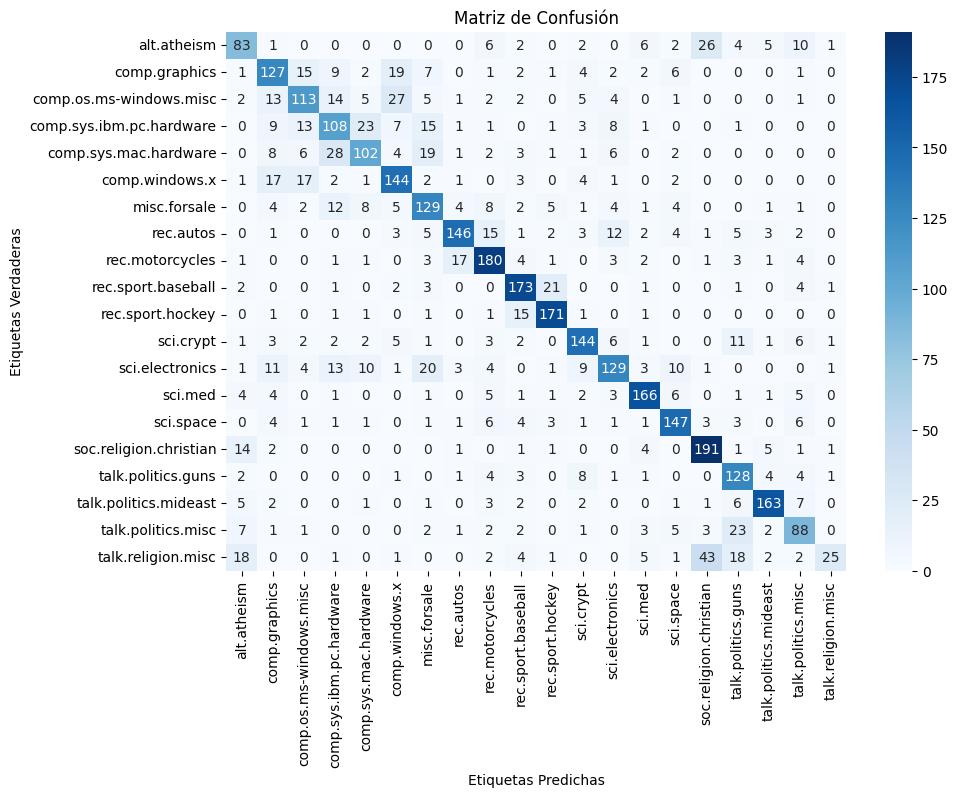

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador XGBoost
#xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',objective='multi:softmax', num_class=20, random_state=42)

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [ 0.01, 0.001],
    'subsample': [0.8 , 1]
}


# Realizar la búsqueda en grilla con validación cruzada
#grid_search = HalvingGridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
#grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
#best_xgb_clf = grid_search.best_estimator_

xgb_clf = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1)

xgb_clf.fit(vectors_train, y_train_num, verbose=1)

# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = xgb_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Métricas en el conjunto de prueba:
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.64      0.62       148
           comp.graphics       0.65      0.71      0.68       199
 comp.os.ms-windows.misc       0.66      0.62      0.64       195
comp.sys.ibm.pc.hardware       0.61      0.60      0.60       191
   comp.sys.mac.hardware       0.64      0.58      0.61       183
          comp.windows.x       0.71      0.72      0.72       195
            misc.forsale       0.67      0.81      0.73       191
               rec.autos       0.85      0.76      0.80       205
         rec.motorcycles       0.80      0.79      0.79       222
      rec.sport.baseball       0.84      0.84      0.84       209
        rec.sport.hockey       0.86      0.88      0.87       193
               sci.crypt       0.84      0.81      0.82       191
         sci.electronics       0.72      0.68      0.70       221
                 sci.med       0.84     

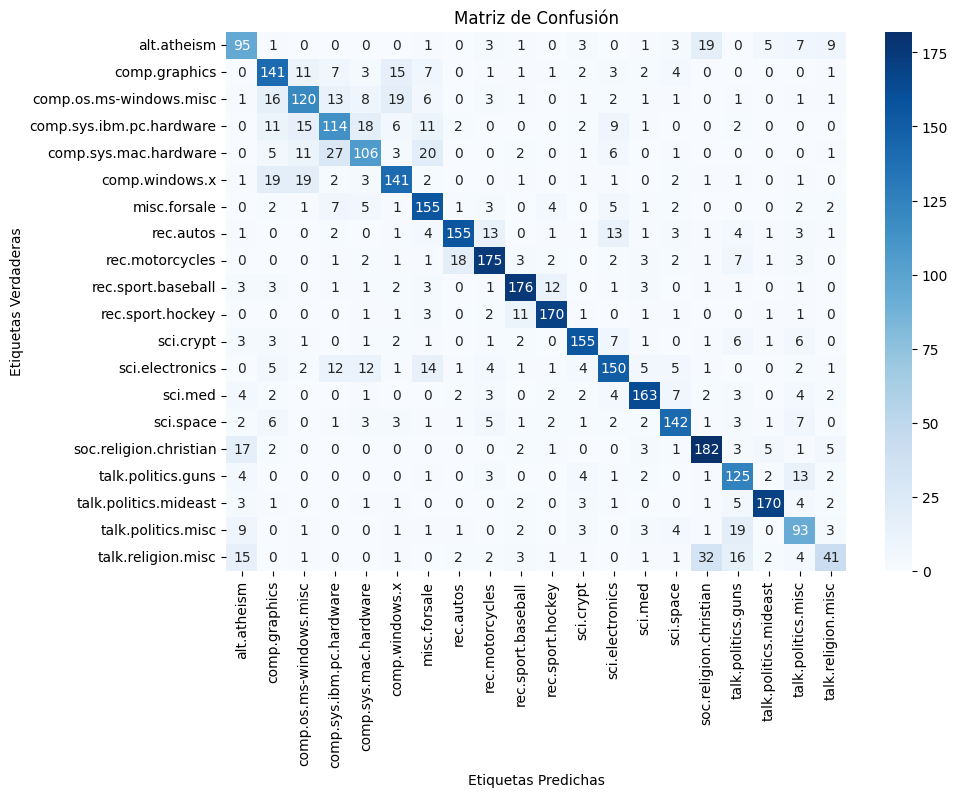

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# RNN

In [ ]:
import tensorflow as tf

# Suponiendo que 'word2vec_embeddings' es una matriz NumPy que contiene tus embeddings de Word2Vec
# y 'max_vocab' es el tamaño de tu vocabulario

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(30000, 300, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20,activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         9000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         186880    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 20)               

In [ ]:
# Configurar el callback de parada temprana
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compilar el modelo con la función de pérdida y el optimizador adecuados para clasificación multiclase
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(vectors_train, y_train_num, epochs=10, validation_data=(vectors_val, y_val_num), batch_size=32, shuffle=True)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-99-a00123f114e7>", line 10, in <cell line: 10>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[5,19] = -1 is not in [0, 30000)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_30826]

In [ ]:
vectors_val.shape

(3013, 300)

In [ ]:
print(y_val_num.shape)

(3013,)
